In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

In [18]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
2


In [19]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [20]:
trainset = datasets.MNIST(root='/scratch/yardima/data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='/scratch/yardima/data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=False, num_workers=2)

tensor([5, 2, 5, 9, 3, 0, 4, 3, 6, 3, 0, 2, 9, 3, 7, 3, 8, 5, 3, 7, 1, 2, 8, 7,
        3, 0, 2, 1, 4, 4, 6, 2])


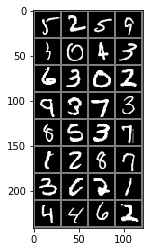

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue

In [21]:
dataiter = iter(trainloader)
i, l = dataiter.next()

g = torchvision.utils.make_grid(i, nrow=4)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

print(l)

## Pre-training

In [22]:
class CNN_pretrain(nn.Module):
    
    def __init__(self):
        super(CNN_pretrain, self).__init__()
        
        self.c1 = nn.Conv2d(1, 16, kernel_size=5)
        self.c2 = nn.Conv2d(16, 32, kernel_size=5)
        self.c3 = nn.Conv2d(32, 32, kernel_size=5)
        self.c4 = nn.Conv2d(32, 16, kernel_size=5)
        self.c5 = nn.Conv2d(16, 10, kernel_size=12)
    
    def forward(self, x):
        
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = self.c5(x)
        
        x = x.view(-1, 10)
        
        return x

In [23]:
cnn_pretrain = CNN_pretrain()
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_pretrain.parameters(), lr = 1e-3, momentum=0.9)
lr_update = lambda epoch: 0.95 ** epoch
cnn_pretrain = cnn_pretrain.to(device)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_update)

In [24]:
%%time
print_step = len(trainset) // (trainloader.batch_size * 4)

for e in range(5):
    running_loss = 0.
    
    for i, batch in enumerate(trainloader, 1):
        x, label = batch
        x, label = x.to(device), label.to(device)
        
        optimizer.zero_grad()
        out = cnn_pretrain.forward(x)
        loss = loss_fun(out, label)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_step == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i, running_loss / print_step))
            running_loss = 0.

[1,   468] loss: 1.134
[1,   936] loss: 0.295
[1,  1404] loss: 0.197
[1,  1872] loss: 0.148
[2,   468] loss: 0.124
[2,   936] loss: 0.111
[2,  1404] loss: 0.101
[2,  1872] loss: 0.096
[3,   468] loss: 0.087
[3,   936] loss: 0.072
[3,  1404] loss: 0.081
[3,  1872] loss: 0.069
[4,   468] loss: 0.066
[4,   936] loss: 0.065
[4,  1404] loss: 0.054
[4,  1872] loss: 0.063
[5,   468] loss: 0.053
[5,   936] loss: 0.048
[5,  1404] loss: 0.052
[5,  1872] loss: 0.054
CPU times: user 28 s, sys: 4.45 s, total: 32.5 s
Wall time: 1min 9s


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_pretrain(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}%'.format(
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98.43%


## Test metric learning/CNN

In [26]:
class CNN(nn.Module):
    
    def __init__(self, *, embed_dim):
        super(CNN, self).__init__()
        
        self.c1 = nn.Conv2d(1, 16, kernel_size=5)
        self.c2 = nn.Conv2d(16, 32, kernel_size=5)
        self.c3 = nn.Conv2d(32, 32, kernel_size=5)
        self.c4 = nn.Conv2d(32, 16, kernel_size=5)
        self.embed_layer = nn.Conv2d(16, embed_dim, kernel_size=12)
        
        self.EMBED_DIM = embed_dim
    
    def forward(self, x):
        
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = F.relu(self.c4(x))
        x = self.embed_layer(x)
        
        x = x.view(-1, self.EMBED_DIM)
        
        return x
    
    def load_pretrained(self, cnn_pretrained):   
        params1 = cnn_pretrained.named_parameters()
        params2 = self.named_parameters()

        dict_params2 = dict(params2)

        for name1, param1 in params1:
            if name1 in dict_params2:
                dict_params2[name1].data.copy_(param1.data)

        self.load_state_dict(dict_params2)
        

In [27]:
cnn = CNN(embed_dim=10)

## print number of parameters in network:
pcount = 0
for p in cnn.parameters():
    pcount += p.numel()
    
print("Total trainable parameter count: {}".format(pcount))

Total trainable parameter count: 74746


## Prepare dataset for triplet loss

In [28]:
classindices = []
trainy = trainset.train_labels.data.numpy()
for i in range(10):
    classindices.append(np.nonzero(trainy == i)[0])

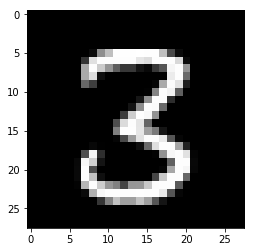

In [29]:
sample = trainset[classindices[3][447]][0]
g = torchvision.utils.make_grid(sample, nrow=1)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [30]:
def gen_triplet(dataset, classindices, n_samples):
    X = []
    y = []
    for i in range(n_samples):
        c = np.random.choice(10, size=2, replace=False)
        
        p_samples = np.random.choice(classindices[c[0]], size=2, replace=False)
        n_sample = np.random.choice(classindices[c[1]], size=1)
        
        X.append(dataset[p_samples[0]][0])
        X.append(dataset[p_samples[1]][0])
        X.append(dataset[n_sample[0]][0])
        
        y.append(dataset[p_samples[0]][1])
        y.append(dataset[p_samples[1]][1])
        y.append(dataset[n_sample[0]][1])
        
    print(y)
        
    return (torch.stack(X), 
            torch.stack(y))

## Train model with different hyper-parameters

In [31]:
def triplet_loss(loss_fun, output, n_samples, target, reg):
    ix = np.arange(n_samples, dtype=np.int32) * 3
    
    distp = (output[ix] - output[ix + 1]).pow(2).sum(dim=1)
    distn = (output[ix] - output[ix + 2]).pow(2).sum(dim=1)
    
    norm_loss = output.pow(2).sum() / n_samples
    loss_dist = loss_fun(distn, distp, target) / n_samples
    
    return reg * norm_loss + loss_dist

In [32]:
cnn = CNN(embed_dim=10)
cnn.load_pretrained(cnn_pretrain)
cnn = cnn.to(device)

optimizer = optim.SGD(cnn.parameters(), lr = 1e-3, momentum=0.9)
lr_update = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_update)

In [33]:
%%time
reg = 1e-3
margin = 1
loss_fun = nn.MarginRankingLoss(margin=margin)
n_samples = 3

epoch_size = 10000

for e in range(10):
    running_loss = 0.
    scheduler.step()
    
    for i in range(1, 10000):
        x, label = gen_triplet(trainset, classindices, n_samples)
        x = x.to(device)
        target = torch.FloatTensor(n_samples).fill_(1).to(device)
        
        optimizer.zero_grad()
        out = cnn.forward(x)
        loss = triplet_loss(loss_fun, out, n_samples, target, reg)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 1250 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i, running_loss / 1250))
            running_loss = 0.

[tensor(3), tensor(3), tensor(5), tensor(1), tensor(1), tensor(2), tensor(2), tensor(2), tensor(3)]
[tensor(7), tensor(7), tensor(2), tensor(2), tensor(2), tensor(9), tensor(4), tensor(4), tensor(5)]
[tensor(2), tensor(2), tensor(8), tensor(3), tensor(3), tensor(8), tensor(8), tensor(8), tensor(3)]
[tensor(0), tensor(0), tensor(7), tensor(1), tensor(1), tensor(9), tensor(8), tensor(8), tensor(2)]
[tensor(7), tensor(7), tensor(1), tensor(8), tensor(8), tensor(4), tensor(6), tensor(6), tensor(0)]
[tensor(3), tensor(3), tensor(8), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(2)]
[tensor(1), tensor(1), tensor(6), tensor(9), tensor(9), tensor(1), tensor(6), tensor(6), tensor(8)]
[tensor(7), tensor(7), tensor(0), tensor(0), tensor(0), tensor(4), tensor(7), tensor(7), tensor(8)]
[tensor(4), tensor(4), tensor(8), tensor(5), tensor(5), tensor(4), tensor(5), tensor(5), tensor(8)]
[tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(3), tensor(5), tensor(5), tensor(6)]


[tensor(3), tensor(3), tensor(4), tensor(1), tensor(1), tensor(7), tensor(2), tensor(2), tensor(9)]
[tensor(9), tensor(9), tensor(7), tensor(6), tensor(6), tensor(2), tensor(8), tensor(8), tensor(0)]
[tensor(7), tensor(7), tensor(6), tensor(2), tensor(2), tensor(6), tensor(8), tensor(8), tensor(9)]
[tensor(5), tensor(5), tensor(7), tensor(8), tensor(8), tensor(3), tensor(1), tensor(1), tensor(4)]
[tensor(2), tensor(2), tensor(7), tensor(6), tensor(6), tensor(0), tensor(7), tensor(7), tensor(2)]
[tensor(4), tensor(4), tensor(1), tensor(5), tensor(5), tensor(1), tensor(7), tensor(7), tensor(3)]
[tensor(0), tensor(0), tensor(8), tensor(8), tensor(8), tensor(7), tensor(2), tensor(2), tensor(6)]
[tensor(1), tensor(1), tensor(6), tensor(1), tensor(1), tensor(4), tensor(5), tensor(5), tensor(7)]
[tensor(4), tensor(4), tensor(0), tensor(8), tensor(8), tensor(0), tensor(7), tensor(7), tensor(1)]
[tensor(7), tensor(7), tensor(2), tensor(7), tensor(7), tensor(5), tensor(4), tensor(4), tensor(2)]


[tensor(5), tensor(5), tensor(6), tensor(8), tensor(8), tensor(2), tensor(0), tensor(0), tensor(8)]
[tensor(7), tensor(7), tensor(0), tensor(9), tensor(9), tensor(1), tensor(0), tensor(0), tensor(8)]
[tensor(2), tensor(2), tensor(5), tensor(4), tensor(4), tensor(0), tensor(7), tensor(7), tensor(6)]
[tensor(9), tensor(9), tensor(1), tensor(1), tensor(1), tensor(8), tensor(7), tensor(7), tensor(6)]
[tensor(5), tensor(5), tensor(9), tensor(1), tensor(1), tensor(3), tensor(8), tensor(8), tensor(4)]
[tensor(6), tensor(6), tensor(4), tensor(3), tensor(3), tensor(9), tensor(5), tensor(5), tensor(8)]
[tensor(9), tensor(9), tensor(4), tensor(8), tensor(8), tensor(0), tensor(3), tensor(3), tensor(9)]
[tensor(9), tensor(9), tensor(6), tensor(7), tensor(7), tensor(8), tensor(2), tensor(2), tensor(1)]
[tensor(0), tensor(0), tensor(9), tensor(5), tensor(5), tensor(8), tensor(3), tensor(3), tensor(9)]
[tensor(0), tensor(0), tensor(9), tensor(8), tensor(8), tensor(6), tensor(9), tensor(9), tensor(1)]


[tensor(8), tensor(8), tensor(0), tensor(4), tensor(4), tensor(7), tensor(8), tensor(8), tensor(1)]
[tensor(0), tensor(0), tensor(8), tensor(0), tensor(0), tensor(7), tensor(6), tensor(6), tensor(8)]
[tensor(3), tensor(3), tensor(5), tensor(1), tensor(1), tensor(7), tensor(8), tensor(8), tensor(5)]
[tensor(4), tensor(4), tensor(8), tensor(5), tensor(5), tensor(0), tensor(9), tensor(9), tensor(2)]
[tensor(0), tensor(0), tensor(4), tensor(2), tensor(2), tensor(7), tensor(7), tensor(7), tensor(3)]
[tensor(3), tensor(3), tensor(2), tensor(2), tensor(2), tensor(6), tensor(9), tensor(9), tensor(1)]
[tensor(6), tensor(6), tensor(4), tensor(2), tensor(2), tensor(3), tensor(8), tensor(8), tensor(0)]
[tensor(8), tensor(8), tensor(0), tensor(7), tensor(7), tensor(9), tensor(6), tensor(6), tensor(3)]
[tensor(6), tensor(6), tensor(9), tensor(9), tensor(9), tensor(3), tensor(9), tensor(9), tensor(8)]
[tensor(3), tensor(3), tensor(4), tensor(6), tensor(6), tensor(5), tensor(4), tensor(4), tensor(5)]


[tensor(4), tensor(4), tensor(3), tensor(2), tensor(2), tensor(8), tensor(0), tensor(0), tensor(2)]
[tensor(3), tensor(3), tensor(2), tensor(8), tensor(8), tensor(3), tensor(1), tensor(1), tensor(4)]
[tensor(8), tensor(8), tensor(7), tensor(2), tensor(2), tensor(6), tensor(8), tensor(8), tensor(7)]
[tensor(6), tensor(6), tensor(5), tensor(9), tensor(9), tensor(2), tensor(3), tensor(3), tensor(6)]
[tensor(1), tensor(1), tensor(6), tensor(2), tensor(2), tensor(3), tensor(6), tensor(6), tensor(5)]
[tensor(3), tensor(3), tensor(5), tensor(6), tensor(6), tensor(7), tensor(2), tensor(2), tensor(5)]
[tensor(4), tensor(4), tensor(9), tensor(0), tensor(0), tensor(1), tensor(2), tensor(2), tensor(8)]
[tensor(8), tensor(8), tensor(4), tensor(0), tensor(0), tensor(4), tensor(8), tensor(8), tensor(2)]
[tensor(8), tensor(8), tensor(9), tensor(9), tensor(9), tensor(0), tensor(5), tensor(5), tensor(0)]
[tensor(4), tensor(4), tensor(9), tensor(9), tensor(9), tensor(8), tensor(1), tensor(1), tensor(4)]


[tensor(7), tensor(7), tensor(2), tensor(9), tensor(9), tensor(8), tensor(0), tensor(0), tensor(1)]
[tensor(7), tensor(7), tensor(6), tensor(8), tensor(8), tensor(3), tensor(9), tensor(9), tensor(5)]
[tensor(7), tensor(7), tensor(0), tensor(4), tensor(4), tensor(0), tensor(9), tensor(9), tensor(6)]
[tensor(1), tensor(1), tensor(9), tensor(9), tensor(9), tensor(5), tensor(2), tensor(2), tensor(3)]
[tensor(9), tensor(9), tensor(4), tensor(0), tensor(0), tensor(1), tensor(9), tensor(9), tensor(3)]
[tensor(6), tensor(6), tensor(0), tensor(4), tensor(4), tensor(5), tensor(4), tensor(4), tensor(7)]
[tensor(5), tensor(5), tensor(9), tensor(7), tensor(7), tensor(8), tensor(5), tensor(5), tensor(1)]
[tensor(5), tensor(5), tensor(3), tensor(8), tensor(8), tensor(2), tensor(3), tensor(3), tensor(7)]
[tensor(4), tensor(4), tensor(2), tensor(3), tensor(3), tensor(6), tensor(3), tensor(3), tensor(6)]
[tensor(8), tensor(8), tensor(0), tensor(3), tensor(3), tensor(8), tensor(6), tensor(6), tensor(5)]


[tensor(5), tensor(5), tensor(4), tensor(4), tensor(4), tensor(8), tensor(4), tensor(4), tensor(5)]
[tensor(3), tensor(3), tensor(0), tensor(7), tensor(7), tensor(6), tensor(7), tensor(7), tensor(3)]
[tensor(6), tensor(6), tensor(8), tensor(6), tensor(6), tensor(2), tensor(8), tensor(8), tensor(2)]
[tensor(8), tensor(8), tensor(7), tensor(9), tensor(9), tensor(6), tensor(6), tensor(6), tensor(8)]
[tensor(2), tensor(2), tensor(8), tensor(8), tensor(8), tensor(6), tensor(8), tensor(8), tensor(2)]
[tensor(9), tensor(9), tensor(4), tensor(5), tensor(5), tensor(9), tensor(3), tensor(3), tensor(4)]
[tensor(3), tensor(3), tensor(6), tensor(4), tensor(4), tensor(7), tensor(7), tensor(7), tensor(1)]
[tensor(5), tensor(5), tensor(0), tensor(0), tensor(0), tensor(1), tensor(3), tensor(3), tensor(1)]
[tensor(4), tensor(4), tensor(3), tensor(9), tensor(9), tensor(6), tensor(2), tensor(2), tensor(9)]
[tensor(2), tensor(2), tensor(5), tensor(2), tensor(2), tensor(7), tensor(8), tensor(8), tensor(7)]


[tensor(0), tensor(0), tensor(1), tensor(2), tensor(2), tensor(6), tensor(5), tensor(5), tensor(4)]
[tensor(9), tensor(9), tensor(2), tensor(8), tensor(8), tensor(2), tensor(1), tensor(1), tensor(0)]
[tensor(9), tensor(9), tensor(2), tensor(8), tensor(8), tensor(4), tensor(9), tensor(9), tensor(4)]
[tensor(3), tensor(3), tensor(9), tensor(0), tensor(0), tensor(3), tensor(4), tensor(4), tensor(5)]
[tensor(2), tensor(2), tensor(9), tensor(7), tensor(7), tensor(8), tensor(3), tensor(3), tensor(2)]
[tensor(8), tensor(8), tensor(1), tensor(2), tensor(2), tensor(7), tensor(4), tensor(4), tensor(3)]
[tensor(9), tensor(9), tensor(0), tensor(0), tensor(0), tensor(5), tensor(1), tensor(1), tensor(2)]
[tensor(1), tensor(1), tensor(6), tensor(9), tensor(9), tensor(6), tensor(1), tensor(1), tensor(9)]
[tensor(8), tensor(8), tensor(4), tensor(9), tensor(9), tensor(0), tensor(1), tensor(1), tensor(4)]
[tensor(7), tensor(7), tensor(5), tensor(0), tensor(0), tensor(6), tensor(6), tensor(6), tensor(7)]


[tensor(0), tensor(0), tensor(9), tensor(4), tensor(4), tensor(7), tensor(7), tensor(7), tensor(1)]
[tensor(2), tensor(2), tensor(4), tensor(2), tensor(2), tensor(1), tensor(8), tensor(8), tensor(7)]
[tensor(5), tensor(5), tensor(1), tensor(9), tensor(9), tensor(5), tensor(3), tensor(3), tensor(8)]
[tensor(8), tensor(8), tensor(6), tensor(4), tensor(4), tensor(1), tensor(5), tensor(5), tensor(7)]
[tensor(9), tensor(9), tensor(3), tensor(0), tensor(0), tensor(3), tensor(5), tensor(5), tensor(8)]
[tensor(9), tensor(9), tensor(3), tensor(0), tensor(0), tensor(3), tensor(1), tensor(1), tensor(8)]
[tensor(8), tensor(8), tensor(2), tensor(8), tensor(8), tensor(2), tensor(0), tensor(0), tensor(3)]
[tensor(0), tensor(0), tensor(9), tensor(7), tensor(7), tensor(2), tensor(5), tensor(5), tensor(7)]
[tensor(2), tensor(2), tensor(0), tensor(9), tensor(9), tensor(3), tensor(2), tensor(2), tensor(4)]
[tensor(1), tensor(1), tensor(5), tensor(8), tensor(8), tensor(4), tensor(3), tensor(3), tensor(0)]


[tensor(4), tensor(4), tensor(2), tensor(9), tensor(9), tensor(4), tensor(4), tensor(4), tensor(6)]
[tensor(3), tensor(3), tensor(2), tensor(0), tensor(0), tensor(1), tensor(8), tensor(8), tensor(3)]
[tensor(2), tensor(2), tensor(3), tensor(2), tensor(2), tensor(3), tensor(3), tensor(3), tensor(0)]
[tensor(7), tensor(7), tensor(8), tensor(9), tensor(9), tensor(0), tensor(3), tensor(3), tensor(4)]
[tensor(6), tensor(6), tensor(1), tensor(2), tensor(2), tensor(6), tensor(5), tensor(5), tensor(0)]
[tensor(5), tensor(5), tensor(1), tensor(7), tensor(7), tensor(9), tensor(9), tensor(9), tensor(1)]
[tensor(4), tensor(4), tensor(3), tensor(9), tensor(9), tensor(5), tensor(6), tensor(6), tensor(9)]
[tensor(0), tensor(0), tensor(6), tensor(8), tensor(8), tensor(9), tensor(8), tensor(8), tensor(2)]
[tensor(0), tensor(0), tensor(8), tensor(4), tensor(4), tensor(7), tensor(6), tensor(6), tensor(2)]
[tensor(0), tensor(0), tensor(2), tensor(9), tensor(9), tensor(6), tensor(4), tensor(4), tensor(6)]


[tensor(0), tensor(0), tensor(7), tensor(7), tensor(7), tensor(6), tensor(0), tensor(0), tensor(2)]
[tensor(3), tensor(3), tensor(9), tensor(8), tensor(8), tensor(4), tensor(3), tensor(3), tensor(6)]
[tensor(2), tensor(2), tensor(5), tensor(3), tensor(3), tensor(4), tensor(5), tensor(5), tensor(9)]
[tensor(4), tensor(4), tensor(3), tensor(4), tensor(4), tensor(5), tensor(1), tensor(1), tensor(2)]
[tensor(6), tensor(6), tensor(9), tensor(4), tensor(4), tensor(2), tensor(3), tensor(3), tensor(6)]
[tensor(1), tensor(1), tensor(7), tensor(0), tensor(0), tensor(9), tensor(3), tensor(3), tensor(8)]
[tensor(6), tensor(6), tensor(9), tensor(3), tensor(3), tensor(7), tensor(7), tensor(7), tensor(4)]
[tensor(1), tensor(1), tensor(8), tensor(9), tensor(9), tensor(0), tensor(4), tensor(4), tensor(0)]
[tensor(1), tensor(1), tensor(9), tensor(1), tensor(1), tensor(7), tensor(3), tensor(3), tensor(8)]
[tensor(4), tensor(4), tensor(7), tensor(8), tensor(8), tensor(5), tensor(4), tensor(4), tensor(7)]


[tensor(4), tensor(4), tensor(6), tensor(8), tensor(8), tensor(3), tensor(0), tensor(0), tensor(9)]
[tensor(3), tensor(3), tensor(7), tensor(0), tensor(0), tensor(5), tensor(1), tensor(1), tensor(5)]
[tensor(5), tensor(5), tensor(3), tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(1)]
[tensor(0), tensor(0), tensor(9), tensor(0), tensor(0), tensor(7), tensor(6), tensor(6), tensor(2)]
[tensor(1), tensor(1), tensor(6), tensor(1), tensor(1), tensor(0), tensor(8), tensor(8), tensor(3)]
[tensor(9), tensor(9), tensor(1), tensor(2), tensor(2), tensor(0), tensor(6), tensor(6), tensor(4)]
[tensor(7), tensor(7), tensor(0), tensor(0), tensor(0), tensor(3), tensor(3), tensor(3), tensor(7)]
[tensor(7), tensor(7), tensor(6), tensor(7), tensor(7), tensor(3), tensor(1), tensor(1), tensor(9)]
[tensor(4), tensor(4), tensor(1), tensor(2), tensor(2), tensor(0), tensor(1), tensor(1), tensor(6)]
[tensor(6), tensor(6), tensor(0), tensor(8), tensor(8), tensor(7), tensor(5), tensor(5), tensor(6)]


[tensor(9), tensor(9), tensor(1), tensor(6), tensor(6), tensor(0), tensor(7), tensor(7), tensor(2)]
[tensor(8), tensor(8), tensor(3), tensor(4), tensor(4), tensor(2), tensor(6), tensor(6), tensor(1)]
[tensor(2), tensor(2), tensor(7), tensor(9), tensor(9), tensor(1), tensor(3), tensor(3), tensor(9)]
[tensor(8), tensor(8), tensor(4), tensor(2), tensor(2), tensor(4), tensor(0), tensor(0), tensor(8)]
[tensor(3), tensor(3), tensor(2), tensor(7), tensor(7), tensor(6), tensor(5), tensor(5), tensor(3)]
[tensor(3), tensor(3), tensor(2), tensor(4), tensor(4), tensor(8), tensor(3), tensor(3), tensor(2)]
[tensor(6), tensor(6), tensor(7), tensor(9), tensor(9), tensor(6), tensor(5), tensor(5), tensor(0)]
[tensor(5), tensor(5), tensor(9), tensor(0), tensor(0), tensor(2), tensor(4), tensor(4), tensor(6)]
[tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(8), tensor(2), tensor(2), tensor(3)]
[tensor(1), tensor(1), tensor(6), tensor(2), tensor(2), tensor(7), tensor(1), tensor(1), tensor(8)]


[tensor(1), tensor(1), tensor(9), tensor(7), tensor(7), tensor(1), tensor(3), tensor(3), tensor(6)]
[tensor(0), tensor(0), tensor(5), tensor(2), tensor(2), tensor(5), tensor(3), tensor(3), tensor(9)]
[tensor(4), tensor(4), tensor(2), tensor(3), tensor(3), tensor(7), tensor(9), tensor(9), tensor(2)]
[tensor(4), tensor(4), tensor(0), tensor(2), tensor(2), tensor(3), tensor(2), tensor(2), tensor(5)]
[tensor(3), tensor(3), tensor(5), tensor(0), tensor(0), tensor(6), tensor(6), tensor(6), tensor(8)]
[tensor(6), tensor(6), tensor(8), tensor(8), tensor(8), tensor(9), tensor(2), tensor(2), tensor(7)]
[tensor(0), tensor(0), tensor(3), tensor(9), tensor(9), tensor(8), tensor(8), tensor(8), tensor(2)]
[tensor(6), tensor(6), tensor(0), tensor(2), tensor(2), tensor(5), tensor(3), tensor(3), tensor(2)]
[tensor(3), tensor(3), tensor(7), tensor(5), tensor(5), tensor(3), tensor(5), tensor(5), tensor(4)]
[tensor(0), tensor(0), tensor(4), tensor(6), tensor(6), tensor(7), tensor(1), tensor(1), tensor(0)]


[tensor(6), tensor(6), tensor(8), tensor(4), tensor(4), tensor(5), tensor(2), tensor(2), tensor(3)]
[tensor(8), tensor(8), tensor(9), tensor(5), tensor(5), tensor(0), tensor(2), tensor(2), tensor(5)]
[tensor(4), tensor(4), tensor(7), tensor(6), tensor(6), tensor(4), tensor(0), tensor(0), tensor(4)]
[tensor(1), tensor(1), tensor(8), tensor(6), tensor(6), tensor(7), tensor(0), tensor(0), tensor(5)]
[tensor(6), tensor(6), tensor(7), tensor(0), tensor(0), tensor(2), tensor(1), tensor(1), tensor(8)]
[tensor(4), tensor(4), tensor(3), tensor(9), tensor(9), tensor(0), tensor(6), tensor(6), tensor(5)]
[tensor(8), tensor(8), tensor(2), tensor(0), tensor(0), tensor(1), tensor(0), tensor(0), tensor(5)]
[tensor(9), tensor(9), tensor(1), tensor(5), tensor(5), tensor(9), tensor(8), tensor(8), tensor(9)]
[tensor(2), tensor(2), tensor(0), tensor(4), tensor(4), tensor(0), tensor(8), tensor(8), tensor(7)]
[tensor(7), tensor(7), tensor(8), tensor(0), tensor(0), tensor(7), tensor(6), tensor(6), tensor(3)]


[tensor(8), tensor(8), tensor(7), tensor(2), tensor(2), tensor(3), tensor(5), tensor(5), tensor(4)]
[tensor(4), tensor(4), tensor(2), tensor(7), tensor(7), tensor(3), tensor(5), tensor(5), tensor(4)]
[tensor(7), tensor(7), tensor(0), tensor(7), tensor(7), tensor(1), tensor(6), tensor(6), tensor(4)]
[tensor(7), tensor(7), tensor(0), tensor(1), tensor(1), tensor(9), tensor(0), tensor(0), tensor(6)]
[tensor(8), tensor(8), tensor(5), tensor(7), tensor(7), tensor(0), tensor(3), tensor(3), tensor(0)]
[tensor(1), tensor(1), tensor(8), tensor(7), tensor(7), tensor(3), tensor(2), tensor(2), tensor(9)]
[tensor(0), tensor(0), tensor(5), tensor(0), tensor(0), tensor(6), tensor(5), tensor(5), tensor(9)]
[tensor(5), tensor(5), tensor(3), tensor(7), tensor(7), tensor(2), tensor(3), tensor(3), tensor(7)]
[tensor(5), tensor(5), tensor(9), tensor(0), tensor(0), tensor(8), tensor(2), tensor(2), tensor(9)]
[tensor(5), tensor(5), tensor(6), tensor(0), tensor(0), tensor(8), tensor(6), tensor(6), tensor(7)]


[tensor(2), tensor(2), tensor(5), tensor(1), tensor(1), tensor(9), tensor(8), tensor(8), tensor(6)]
[tensor(9), tensor(9), tensor(4), tensor(6), tensor(6), tensor(3), tensor(1), tensor(1), tensor(7)]
[tensor(1), tensor(1), tensor(2), tensor(9), tensor(9), tensor(6), tensor(1), tensor(1), tensor(7)]
[tensor(4), tensor(4), tensor(1), tensor(2), tensor(2), tensor(5), tensor(9), tensor(9), tensor(7)]
[tensor(1), tensor(1), tensor(8), tensor(7), tensor(7), tensor(1), tensor(0), tensor(0), tensor(6)]
[tensor(8), tensor(8), tensor(6), tensor(4), tensor(4), tensor(9), tensor(8), tensor(8), tensor(6)]
[tensor(6), tensor(6), tensor(5), tensor(7), tensor(7), tensor(3), tensor(5), tensor(5), tensor(8)]
[tensor(4), tensor(4), tensor(3), tensor(0), tensor(0), tensor(7), tensor(3), tensor(3), tensor(8)]
[tensor(0), tensor(0), tensor(6), tensor(6), tensor(6), tensor(1), tensor(8), tensor(8), tensor(4)]
[tensor(3), tensor(3), tensor(6), tensor(6), tensor(6), tensor(9), tensor(0), tensor(0), tensor(4)]


[tensor(6), tensor(6), tensor(8), tensor(3), tensor(3), tensor(8), tensor(6), tensor(6), tensor(4)]
[tensor(0), tensor(0), tensor(6), tensor(4), tensor(4), tensor(6), tensor(4), tensor(4), tensor(5)]
[tensor(5), tensor(5), tensor(0), tensor(9), tensor(9), tensor(7), tensor(4), tensor(4), tensor(8)]
[tensor(5), tensor(5), tensor(6), tensor(7), tensor(7), tensor(8), tensor(6), tensor(6), tensor(9)]
[tensor(2), tensor(2), tensor(6), tensor(4), tensor(4), tensor(9), tensor(5), tensor(5), tensor(2)]
[tensor(5), tensor(5), tensor(0), tensor(2), tensor(2), tensor(7), tensor(6), tensor(6), tensor(4)]
[tensor(7), tensor(7), tensor(8), tensor(9), tensor(9), tensor(0), tensor(1), tensor(1), tensor(2)]
[tensor(6), tensor(6), tensor(4), tensor(3), tensor(3), tensor(8), tensor(3), tensor(3), tensor(2)]
[tensor(1), tensor(1), tensor(5), tensor(0), tensor(0), tensor(5), tensor(2), tensor(2), tensor(6)]
[tensor(3), tensor(3), tensor(4), tensor(5), tensor(5), tensor(2), tensor(5), tensor(5), tensor(8)]


[tensor(8), tensor(8), tensor(5), tensor(9), tensor(9), tensor(5), tensor(8), tensor(8), tensor(2)]
[tensor(7), tensor(7), tensor(4), tensor(8), tensor(8), tensor(3), tensor(3), tensor(3), tensor(7)]
[tensor(9), tensor(9), tensor(5), tensor(9), tensor(9), tensor(3), tensor(4), tensor(4), tensor(1)]
[tensor(3), tensor(3), tensor(8), tensor(8), tensor(8), tensor(0), tensor(1), tensor(1), tensor(2)]
[tensor(5), tensor(5), tensor(9), tensor(3), tensor(3), tensor(0), tensor(0), tensor(0), tensor(1)]
[tensor(0), tensor(0), tensor(3), tensor(5), tensor(5), tensor(8), tensor(2), tensor(2), tensor(9)]
[tensor(8), tensor(8), tensor(5), tensor(4), tensor(4), tensor(6), tensor(7), tensor(7), tensor(2)]
[tensor(5), tensor(5), tensor(0), tensor(4), tensor(4), tensor(8), tensor(3), tensor(3), tensor(5)]
[tensor(8), tensor(8), tensor(3), tensor(1), tensor(1), tensor(2), tensor(6), tensor(6), tensor(9)]
[tensor(4), tensor(4), tensor(8), tensor(3), tensor(3), tensor(5), tensor(5), tensor(5), tensor(9)]


[tensor(3), tensor(3), tensor(4), tensor(6), tensor(6), tensor(3), tensor(1), tensor(1), tensor(5)]
[tensor(6), tensor(6), tensor(9), tensor(4), tensor(4), tensor(7), tensor(5), tensor(5), tensor(1)]
[tensor(3), tensor(3), tensor(6), tensor(6), tensor(6), tensor(0), tensor(3), tensor(3), tensor(4)]
[tensor(4), tensor(4), tensor(5), tensor(8), tensor(8), tensor(4), tensor(1), tensor(1), tensor(3)]
[tensor(7), tensor(7), tensor(0), tensor(4), tensor(4), tensor(3), tensor(0), tensor(0), tensor(4)]
[tensor(2), tensor(2), tensor(4), tensor(7), tensor(7), tensor(8), tensor(9), tensor(9), tensor(7)]
[tensor(9), tensor(9), tensor(6), tensor(9), tensor(9), tensor(7), tensor(6), tensor(6), tensor(7)]
[tensor(8), tensor(8), tensor(5), tensor(4), tensor(4), tensor(1), tensor(1), tensor(1), tensor(6)]
[tensor(6), tensor(6), tensor(7), tensor(7), tensor(7), tensor(8), tensor(9), tensor(9), tensor(2)]
[tensor(8), tensor(8), tensor(1), tensor(8), tensor(8), tensor(4), tensor(7), tensor(7), tensor(0)]


[tensor(2), tensor(2), tensor(8), tensor(8), tensor(8), tensor(1), tensor(4), tensor(4), tensor(9)]
[tensor(9), tensor(9), tensor(2), tensor(5), tensor(5), tensor(0), tensor(7), tensor(7), tensor(5)]
[tensor(5), tensor(5), tensor(6), tensor(6), tensor(6), tensor(2), tensor(9), tensor(9), tensor(2)]
[tensor(5), tensor(5), tensor(7), tensor(1), tensor(1), tensor(7), tensor(7), tensor(7), tensor(2)]
[tensor(1), tensor(1), tensor(8), tensor(4), tensor(4), tensor(8), tensor(2), tensor(2), tensor(1)]
[tensor(1), tensor(1), tensor(5), tensor(4), tensor(4), tensor(0), tensor(5), tensor(5), tensor(7)]
[tensor(8), tensor(8), tensor(9), tensor(7), tensor(7), tensor(3), tensor(6), tensor(6), tensor(9)]
[tensor(7), tensor(7), tensor(1), tensor(8), tensor(8), tensor(0), tensor(4), tensor(4), tensor(7)]
[tensor(9), tensor(9), tensor(6), tensor(3), tensor(3), tensor(8), tensor(4), tensor(4), tensor(5)]
[tensor(4), tensor(4), tensor(7), tensor(1), tensor(1), tensor(7), tensor(7), tensor(7), tensor(5)]


[tensor(2), tensor(2), tensor(0), tensor(2), tensor(2), tensor(5), tensor(0), tensor(0), tensor(9)]
[tensor(2), tensor(2), tensor(7), tensor(8), tensor(8), tensor(0), tensor(4), tensor(4), tensor(7)]
[tensor(9), tensor(9), tensor(6), tensor(5), tensor(5), tensor(8), tensor(8), tensor(8), tensor(5)]
[tensor(1), tensor(1), tensor(3), tensor(0), tensor(0), tensor(8), tensor(0), tensor(0), tensor(2)]
[tensor(6), tensor(6), tensor(4), tensor(3), tensor(3), tensor(7), tensor(0), tensor(0), tensor(4)]
[tensor(6), tensor(6), tensor(1), tensor(1), tensor(1), tensor(9), tensor(2), tensor(2), tensor(1)]
[tensor(6), tensor(6), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(4), tensor(5)]
[tensor(1), tensor(1), tensor(6), tensor(6), tensor(6), tensor(1), tensor(2), tensor(2), tensor(9)]
[tensor(8), tensor(8), tensor(5), tensor(3), tensor(3), tensor(0), tensor(2), tensor(2), tensor(7)]
[tensor(4), tensor(4), tensor(5), tensor(6), tensor(6), tensor(7), tensor(9), tensor(9), tensor(8)]


[tensor(3), tensor(3), tensor(1), tensor(0), tensor(0), tensor(2), tensor(1), tensor(1), tensor(9)]
[tensor(0), tensor(0), tensor(4), tensor(4), tensor(4), tensor(6), tensor(1), tensor(1), tensor(9)]
[tensor(6), tensor(6), tensor(8), tensor(6), tensor(6), tensor(5), tensor(5), tensor(5), tensor(6)]
[tensor(5), tensor(5), tensor(9), tensor(0), tensor(0), tensor(5), tensor(7), tensor(7), tensor(6)]
[tensor(7), tensor(7), tensor(2), tensor(6), tensor(6), tensor(1), tensor(4), tensor(4), tensor(1)]
[tensor(5), tensor(5), tensor(4), tensor(5), tensor(5), tensor(1), tensor(8), tensor(8), tensor(4)]
[tensor(5), tensor(5), tensor(3), tensor(2), tensor(2), tensor(9), tensor(5), tensor(5), tensor(3)]
[tensor(9), tensor(9), tensor(1), tensor(5), tensor(5), tensor(7), tensor(2), tensor(2), tensor(7)]
[tensor(2), tensor(2), tensor(9), tensor(1), tensor(1), tensor(4), tensor(1), tensor(1), tensor(9)]
[tensor(4), tensor(4), tensor(8), tensor(6), tensor(6), tensor(9), tensor(8), tensor(8), tensor(1)]


[tensor(3), tensor(3), tensor(9), tensor(7), tensor(7), tensor(8), tensor(0), tensor(0), tensor(3)]
[tensor(3), tensor(3), tensor(9), tensor(5), tensor(5), tensor(8), tensor(6), tensor(6), tensor(0)]
[tensor(9), tensor(9), tensor(7), tensor(4), tensor(4), tensor(8), tensor(3), tensor(3), tensor(0)]
[tensor(2), tensor(2), tensor(5), tensor(0), tensor(0), tensor(5), tensor(6), tensor(6), tensor(8)]
[tensor(5), tensor(5), tensor(8), tensor(8), tensor(8), tensor(3), tensor(7), tensor(7), tensor(3)]
[tensor(9), tensor(9), tensor(5), tensor(2), tensor(2), tensor(3), tensor(2), tensor(2), tensor(6)]
[tensor(5), tensor(5), tensor(3), tensor(8), tensor(8), tensor(6), tensor(3), tensor(3), tensor(8)]
[tensor(1), tensor(1), tensor(4), tensor(2), tensor(2), tensor(6), tensor(5), tensor(5), tensor(9)]
[tensor(6), tensor(6), tensor(3), tensor(8), tensor(8), tensor(9), tensor(6), tensor(6), tensor(7)]
[tensor(7), tensor(7), tensor(5), tensor(8), tensor(8), tensor(0), tensor(9), tensor(9), tensor(6)]


[tensor(5), tensor(5), tensor(0), tensor(7), tensor(7), tensor(3), tensor(5), tensor(5), tensor(6)]
[tensor(0), tensor(0), tensor(9), tensor(2), tensor(2), tensor(4), tensor(3), tensor(3), tensor(6)]
[tensor(3), tensor(3), tensor(0), tensor(2), tensor(2), tensor(3), tensor(9), tensor(9), tensor(7)]
[tensor(1), tensor(1), tensor(9), tensor(7), tensor(7), tensor(1), tensor(1), tensor(1), tensor(2)]
[tensor(0), tensor(0), tensor(2), tensor(6), tensor(6), tensor(2), tensor(6), tensor(6), tensor(5)]
[tensor(4), tensor(4), tensor(5), tensor(1), tensor(1), tensor(5), tensor(0), tensor(0), tensor(9)]
[tensor(1), tensor(1), tensor(9), tensor(3), tensor(3), tensor(8), tensor(7), tensor(7), tensor(6)]
[tensor(9), tensor(9), tensor(0), tensor(0), tensor(0), tensor(2), tensor(6), tensor(6), tensor(2)]
[tensor(0), tensor(0), tensor(5), tensor(2), tensor(2), tensor(1), tensor(5), tensor(5), tensor(9)]
[tensor(3), tensor(3), tensor(4), tensor(3), tensor(3), tensor(2), tensor(0), tensor(0), tensor(3)]


[tensor(8), tensor(8), tensor(2), tensor(2), tensor(2), tensor(7), tensor(8), tensor(8), tensor(3)]
[tensor(7), tensor(7), tensor(4), tensor(3), tensor(3), tensor(2), tensor(4), tensor(4), tensor(5)]
[tensor(8), tensor(8), tensor(9), tensor(7), tensor(7), tensor(0), tensor(5), tensor(5), tensor(2)]
[tensor(0), tensor(0), tensor(6), tensor(4), tensor(4), tensor(9), tensor(0), tensor(0), tensor(6)]
[tensor(9), tensor(9), tensor(6), tensor(1), tensor(1), tensor(5), tensor(5), tensor(5), tensor(2)]
[tensor(0), tensor(0), tensor(6), tensor(8), tensor(8), tensor(6), tensor(5), tensor(5), tensor(8)]
[tensor(3), tensor(3), tensor(4), tensor(0), tensor(0), tensor(9), tensor(8), tensor(8), tensor(9)]
[tensor(6), tensor(6), tensor(4), tensor(8), tensor(8), tensor(7), tensor(0), tensor(0), tensor(2)]
[tensor(1), tensor(1), tensor(8), tensor(9), tensor(9), tensor(8), tensor(5), tensor(5), tensor(8)]
[tensor(9), tensor(9), tensor(7), tensor(8), tensor(8), tensor(0), tensor(3), tensor(3), tensor(5)]


[tensor(5), tensor(5), tensor(0), tensor(8), tensor(8), tensor(1), tensor(5), tensor(5), tensor(3)]
[tensor(6), tensor(6), tensor(7), tensor(4), tensor(4), tensor(6), tensor(6), tensor(6), tensor(9)]
[tensor(9), tensor(9), tensor(6), tensor(5), tensor(5), tensor(4), tensor(8), tensor(8), tensor(7)]
[tensor(5), tensor(5), tensor(8), tensor(6), tensor(6), tensor(4), tensor(7), tensor(7), tensor(3)]
[tensor(2), tensor(2), tensor(4), tensor(7), tensor(7), tensor(1), tensor(8), tensor(8), tensor(1)]
[tensor(6), tensor(6), tensor(5), tensor(8), tensor(8), tensor(9), tensor(3), tensor(3), tensor(7)]
[tensor(5), tensor(5), tensor(6), tensor(0), tensor(0), tensor(2), tensor(5), tensor(5), tensor(1)]
[tensor(1), tensor(1), tensor(9), tensor(7), tensor(7), tensor(0), tensor(9), tensor(9), tensor(6)]
[tensor(8), tensor(8), tensor(2), tensor(7), tensor(7), tensor(1), tensor(6), tensor(6), tensor(5)]
[tensor(9), tensor(9), tensor(5), tensor(4), tensor(4), tensor(5), tensor(5), tensor(5), tensor(2)]


[tensor(1), tensor(1), tensor(5), tensor(1), tensor(1), tensor(6), tensor(9), tensor(9), tensor(2)]
[tensor(9), tensor(9), tensor(1), tensor(3), tensor(3), tensor(8), tensor(0), tensor(0), tensor(5)]
[tensor(9), tensor(9), tensor(6), tensor(9), tensor(9), tensor(3), tensor(2), tensor(2), tensor(5)]
[tensor(7), tensor(7), tensor(6), tensor(3), tensor(3), tensor(9), tensor(0), tensor(0), tensor(1)]
[tensor(6), tensor(6), tensor(3), tensor(3), tensor(3), tensor(9), tensor(5), tensor(5), tensor(0)]
[tensor(6), tensor(6), tensor(1), tensor(5), tensor(5), tensor(2), tensor(1), tensor(1), tensor(7)]
[tensor(2), tensor(2), tensor(1), tensor(2), tensor(2), tensor(4), tensor(9), tensor(9), tensor(7)]
[tensor(2), tensor(2), tensor(8), tensor(5), tensor(5), tensor(0), tensor(2), tensor(2), tensor(9)]
[tensor(7), tensor(7), tensor(4), tensor(6), tensor(6), tensor(5), tensor(2), tensor(2), tensor(9)]
[tensor(7), tensor(7), tensor(3), tensor(0), tensor(0), tensor(3), tensor(3), tensor(3), tensor(0)]


[tensor(6), tensor(6), tensor(5), tensor(9), tensor(9), tensor(4), tensor(2), tensor(2), tensor(3)]
[tensor(4), tensor(4), tensor(7), tensor(3), tensor(3), tensor(0), tensor(0), tensor(0), tensor(1)]
[tensor(9), tensor(9), tensor(6), tensor(6), tensor(6), tensor(9), tensor(2), tensor(2), tensor(4)]
[tensor(9), tensor(9), tensor(7), tensor(6), tensor(6), tensor(3), tensor(7), tensor(7), tensor(9)]
[tensor(0), tensor(0), tensor(1), tensor(7), tensor(7), tensor(3), tensor(3), tensor(3), tensor(5)]
[tensor(0), tensor(0), tensor(5), tensor(0), tensor(0), tensor(8), tensor(8), tensor(8), tensor(3)]
[tensor(5), tensor(5), tensor(4), tensor(6), tensor(6), tensor(2), tensor(4), tensor(4), tensor(3)]
[tensor(5), tensor(5), tensor(0), tensor(4), tensor(4), tensor(5), tensor(6), tensor(6), tensor(2)]
[tensor(1), tensor(1), tensor(9), tensor(4), tensor(4), tensor(5), tensor(0), tensor(0), tensor(5)]
[tensor(7), tensor(7), tensor(0), tensor(0), tensor(0), tensor(9), tensor(6), tensor(6), tensor(3)]


[tensor(1), tensor(1), tensor(2), tensor(9), tensor(9), tensor(6), tensor(4), tensor(4), tensor(7)]
[tensor(7), tensor(7), tensor(8), tensor(5), tensor(5), tensor(7), tensor(7), tensor(7), tensor(9)]
[tensor(5), tensor(5), tensor(6), tensor(1), tensor(1), tensor(6), tensor(1), tensor(1), tensor(7)]
[tensor(8), tensor(8), tensor(9), tensor(1), tensor(1), tensor(3), tensor(9), tensor(9), tensor(4)]
[tensor(1), tensor(1), tensor(2), tensor(9), tensor(9), tensor(0), tensor(6), tensor(6), tensor(2)]
[tensor(8), tensor(8), tensor(1), tensor(9), tensor(9), tensor(7), tensor(5), tensor(5), tensor(8)]
[tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(5), tensor(4), tensor(4), tensor(9)]
[tensor(8), tensor(8), tensor(3), tensor(9), tensor(9), tensor(1), tensor(7), tensor(7), tensor(1)]
[tensor(4), tensor(4), tensor(5), tensor(8), tensor(8), tensor(1), tensor(7), tensor(7), tensor(9)]
[tensor(8), tensor(8), tensor(0), tensor(7), tensor(7), tensor(5), tensor(7), tensor(7), tensor(5)]


[tensor(4), tensor(4), tensor(3), tensor(8), tensor(8), tensor(9), tensor(2), tensor(2), tensor(5)]
[tensor(9), tensor(9), tensor(6), tensor(8), tensor(8), tensor(3), tensor(3), tensor(3), tensor(8)]
[tensor(0), tensor(0), tensor(3), tensor(5), tensor(5), tensor(4), tensor(0), tensor(0), tensor(1)]
[tensor(1), tensor(1), tensor(3), tensor(3), tensor(3), tensor(5), tensor(7), tensor(7), tensor(3)]
[tensor(5), tensor(5), tensor(4), tensor(5), tensor(5), tensor(1), tensor(1), tensor(1), tensor(4)]
[tensor(0), tensor(0), tensor(9), tensor(0), tensor(0), tensor(4), tensor(3), tensor(3), tensor(8)]
[tensor(7), tensor(7), tensor(3), tensor(2), tensor(2), tensor(0), tensor(0), tensor(0), tensor(2)]
[tensor(6), tensor(6), tensor(3), tensor(0), tensor(0), tensor(3), tensor(0), tensor(0), tensor(4)]
[tensor(8), tensor(8), tensor(5), tensor(5), tensor(5), tensor(0), tensor(8), tensor(8), tensor(1)]
[tensor(8), tensor(8), tensor(9), tensor(7), tensor(7), tensor(4), tensor(6), tensor(6), tensor(2)]


KeyboardInterrupt: 

In [34]:
hasnan = False
for p in cnn.parameters():
    print(p.data)
    
print(hasnan)

tensor([[[[-0.0977,  0.1403, -0.0642,  0.0663,  0.1187],
          [ 0.1629,  0.0750, -0.0198,  0.0041, -0.1960],
          [-0.0984,  0.1427, -0.0986,  0.0038, -0.1874],
          [ 0.2057,  0.1983,  0.0316, -0.0764,  0.1029],
          [ 0.0768, -0.1550,  0.0353,  0.0511, -0.1932]]],


        [[[ 0.2414, -0.1032, -0.0854, -0.0411, -0.0110],
          [-0.0531, -0.1605,  0.0569, -0.2341, -0.1467],
          [ 0.0034,  0.0356, -0.0881, -0.0526, -0.1472],
          [ 0.0236, -0.1222, -0.0381, -0.0524, -0.0070],
          [ 0.0949,  0.1318, -0.0073,  0.1219,  0.1512]]],


        [[[ 0.1771, -0.1103, -0.1321,  0.0974, -0.1247],
          [ 0.1249,  0.1923,  0.0149, -0.1059, -0.1404],
          [-0.1931,  0.1984, -0.1011,  0.1008, -0.0769],
          [ 0.0877,  0.2061,  0.0336, -0.1606, -0.1182],
          [-0.0507, -0.1887, -0.0232, -0.0143,  0.1813]]],


        [[[ 0.0263, -0.0946, -0.0671,  0.1031, -0.0356],
          [-0.0320,  0.0145, -0.2548, -0.1696,  0.1391],
          [ 0.1678,

tensor([[[[ 0.0270, -0.0084,  0.0151,  0.0268,  0.0238],
          [-0.0042,  0.0114, -0.0028,  0.0080, -0.0158],
          [ 0.0102,  0.0062,  0.0198,  0.0029,  0.0264],
          [-0.0242,  0.0270, -0.0111,  0.0249, -0.0054],
          [ 0.0030, -0.0113,  0.0038, -0.0112,  0.0241]],

         [[-0.0401, -0.0840, -0.0577, -0.0788, -0.0416],
          [ 0.0111, -0.0492, -0.0488, -0.0069, -0.0642],
          [-0.0256, -0.0053,  0.0139, -0.0471,  0.0158],
          [ 0.0344, -0.0252, -0.0355, -0.0323,  0.0177],
          [-0.0025, -0.0137,  0.0050,  0.0106, -0.0223]],

         [[ 0.0364,  0.0228,  0.0190, -0.0327, -0.0147],
          [ 0.0292,  0.0427,  0.0042,  0.0060, -0.0174],
          [ 0.0476,  0.0025,  0.0331,  0.0376, -0.0246],
          [-0.0052,  0.0107,  0.0295,  0.0321,  0.0114],
          [ 0.0167,  0.0638,  0.0099,  0.0706,  0.0375]],

         ...,

         [[-0.0270, -0.0229,  0.0110, -0.0286, -0.0278],
          [ 0.0206,  0.0248,  0.0017,  0.0067, -0.0022],
          

RuntimeError: DataLoader worker (pid 27250) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [ ]:
torch.save(cnn, '/home/yardima/Python/models/model2_pretrained')

## Evaluate model

In [ ]:
# load model
embed_model = torch.load('/home/yardima/Python/models/model2_pretrained')
embed_model.to(device)

In [ ]:
%%time
train_embed = []
train_label = []
with torch.autograd.no_grad():
    for x, label in trainset:
        x = x.to(device).view(1, 1, 28, 28)
        y = embed_model.forward(x).cpu().data.numpy()
        train_embed.append(y)
        train_label.append(label.item())
        
train_embed = np.array(train_embed)
train_label = np.array(train_label, dtype=np.int32)

In [ ]:
train_embed = train_embed.reshape((-1, embed_model.EMBED_DIM))

In [ ]:
test_embed = []
test_label = []
with torch.autograd.no_grad():
    for x, label in testset:
        x = x.to(device).view(1, 1, 28, 28)
        y = embed_model.forward(x).cpu().data.numpy()
        test_embed.append(y)
        test_label.append(label.item())
        
test_embed = np.array(test_embed)
test_label = np.array(test_label, dtype=np.int32)

In [ ]:
test_embed = test_embed.reshape((-1, embed_model.EMBED_DIM))

### k-NN classification on learned embeddings

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

nn1_classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=8)
nn3_classifier = KNeighborsClassifier(n_neighbors=3, n_jobs=8)
nn5_classifier = KNeighborsClassifier(n_neighbors=5, n_jobs=8)

In [ ]:
nn1_classifier.fit(train_embed, train_label)
nn3_classifier.fit(train_embed, train_label)
nn5_classifier.fit(train_embed, train_label)

In [ ]:
%%time
pred1 = nn1_classifier.predict(test_embed)

In [ ]:
%%time
pred3 = nn3_classifier.predict(test_embed)

In [ ]:
%%time
pred5 = nn5_classifier.predict(test_embed)

In [ ]:
print("k-NN classification on MNIST embeddings (k=1)")
print(np.mean(pred1 == test_label))
print("k-NN classification on MNIST embeddings (k=3)")
print(np.mean(pred3 == test_label))
print("k-NN classification on MNIST embeddings (k=5)")
print(np.mean(pred5 == test_label))

In [ ]:
%%time
nn7_classifier = KNeighborsClassifier(n_neighbors=7, n_jobs=8)
nn7_classifier.fit(train_embed, train_label)
pred7 = nn7_classifier.predict(test_embed)
print("k-NN classification on MNIST embeddings (k=7)")
print(np.mean(pred7 == test_label))

In [ ]:
%%time
nn15_classifier = KNeighborsClassifier(n_neighbors=15, n_jobs=8)
nn15_classifier.fit(train_embed, train_label)
pred15 = nn15_classifier.predict(test_embed)
print("k-NN classification on MNIST embeddings (k=15)")
print(np.mean(pred15 == test_label))

## Test t-SNE plots

In [ ]:
from sklearn.manifold import TSNE

ix = np.random.choice(np.arange(test_embed.shape[0]), size=2000, replace=False)
test_embed_subsample = test_embed[ix]
test_label_subsample = test_label[ix]
tsne_embedding = TSNE(n_components=2).fit_transform(test_embed_subsample)

In [ ]:
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=test_label_subsample)